# Imports

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

import warnings
warnings.filterwarnings('ignore')

from utils import reader
config = reader.read_config()

# Введение

Давайте рассмотрим простой **two-sided t-test**, где мы проверяем следующие гипотезы:

\begin{align}
H_0 &: \overline{Y}^{C} = \overline{Y}^{T} & H_1 &: \overline{Y}^{C} \neq \overline{Y}^{T} 
\end{align}
где,
* $Y$ - интересующая нас метрика (например, revenue_7)
* $C$ - обозначает контрольную группу
* $T$ - обозначает тестовую группу

То есть мы проверяем гипотезу о равенстве средних метрики $Y$ между группами $C$ и $T$

Для проверки этой гипотезы нам нужно посчитать **t-statistic** следующим образом:
\begin{align}
T &= \frac{\bar{Y}^T - \bar{Y}^C}{\sqrt\frac{{var(\bar{Y}^T - \bar{Y}^C)}}{n}}
\end{align}
или
$$
T = \frac{\triangle}{\sqrt\frac{{var(\triangle)}}{n}}
$$
где,
* $\triangle = \bar{Y}^T - \bar{Y}^C$ - это несмещенная оценка аплифта, а **t-statistic** в свою очередь является нормализованной версией аплифта

Также стоит учитывать, что **t-statistic** и **p-value** имеют обратную взаимосвязь - чем больше $T$, тем меньше $p-value$. Таким образом, если мы сможем уменьшить дисперсию разницы между средними, то мы сможем уменьшить 

Давайте разложим эту дисперсию:

\begin{align}
var(\triangle) &= var({Y}^T - {Y}^C) \\&= var(Y^T) + var(-Y^C) - 2cov(Y^T, Y^C) \\&= var(Y^T) + var(Y^C)
\end{align}

Получается мы сможем уменьшить дисперсию аплифта только если сможем уменьшить дисперсию самих метрик $Y^T$ и $Y^C$

В основном эту задачу решают следующим образом - мы хотим найти новую оценка аплифта, $\triangle*$, таким образом, что
* $\triangle*$ - является несмещенной оценкой аплифта, как и $\triangle$
* $\triangle*$ - имеет дисперсию меньше, чем $\triangle$

Для ускорения теста нам нужно увеличить значение $T$. Этого можно достичь либо увеличением аплифта, либо уменьшением стандартной ошибки. А стандартная ошибка же в свою очередь уменьшается либо уменьшением дисперсии аплифта либо увеличением выборки

Мы не имеем контроля над аплифтом. Значит мы можем только управлять стандартной ошибкой. То есть мы можем увеличить кол-во наблюдений. А если это не является возможным, то мы можем ухищряться по уменьшению дисперсии

Именно поэтому и были придуманы следующие методы

# Linear Models

Давайте опять вернемся к проверке гипотезы

\begin{align}
H_0 &: \bar{Y}^{C} = \bar{Y}^{T} & H_1 &: \bar{Y}^{C} \neq \bar{Y}^{T} 
\end{align}

Данную гипотезу мы можем проверить с помощью простого __t-test__

Нулевая гипотеза верна - два сэмпла с большой вероятностью взяты из одного и того же распределения
Альтернативная гипотеза верна - мы отвергаем нулевую гипотезу, а не потверждаем альтернативную

То есть, при проверке гипотезы мы хотим проверить не взяты ли сэмплы из одного и того же распределения

Но мы можем гипотезу переформулировать в линейную регрессию следующим образом:

$$
E(Y_i|Z_i, X_i) = \theta_0 + \delta T_i + \theta^TX_i
$$
где,
* Y - результаты (напр., те же revenue_7 полученные по ходу теста)
* T - индикатор групп (1 - контрольная группа, 0 - тестовая группа)
* $\theta$ - коэффициенты линейной регрессий
* $\delta$ - тоже коэффициент линейной регрессий, которую можно воспринимать как оценку аплифта $\triangle*$

Получив результаты для этой линейной регрессии мы проверим гипотезу сверху

Для этого нужно вспомнить Regression Analysis: после получения коэффициентов $\theta_i$ мы можем проверить через тот же __t-test__, что наши фичи имеют эффект на целевую переменную. В нашем случае, мы проверяем, что свободный член и индикатор групп релеванты по отношению к целевой переменной.

И самое интересное, что $p-value$ и $t-statistic$ для коэффициента $\theta_1$ идентичны тому, что бы мы получили через проверку гипотезы выше

Тем самым линейная проверка гипотезы и линейная регрессия для нас равнозначны.

На этом факте и строятся линейные техники ускорения тестов

## Post-stratification

Пост-стратификация - это метод, при котором мы пытаемся полученные результаты разбить на страты (слои) и тем самым уменьшить. 

То есть мы хотим в линейную регрессию засунуть какие-то категориальные фичи

$$
E(Y_i|Z_i) = \theta_0 + \theta_1Z_i + \theta_2X_i
$$

тут $X_i$ - это какие-то категориальные фичи для разделения на страты

Идея в том, чтобы поделить выборку на $k$ страт (сегментов). Общая дисперсия выборки будет равна средневзвешенной средней дисперсий страт, таким образом зануляется межгрупповая дисперсия.

Математически, 
\begin{align}
var(Y) &= \sum_{k=1}^{n}\frac{w_k}{n}\sigma^2_k + \sum_{k=1}^{n}\frac{w_k}{n}(\mu_k - \mu)^2 \\&\geq \sum_{k=1}^{n}\frac{w_k}{n}\sigma^2_k = var(\hat{Y}_{strat})
\end{align}
где,
* $\mu_k$ - среднее $k$-той страты
* $\sigma_k^2$ - дисперсия $k$-той страты

По формуле выше видно, что для уменьшения дисперсии нужно, чтобы средние страт и общее среднее сильнее отличались. То есть если страты будут представлять собой рандомные бакеты, то мы получим нулевое уменьшение дисперсий

### Hands-on

Давайте теперь на синтетических данных проверим данный метод

Я тут подготовил код, который генерит данные по 4 стратам, которые имеют разные выборочные средние и дисперсии

Математически это выглядит следующим образом:

$$
\{X: x_1, x_2, x_3, x_4 \}
$$
где $x_k$ ~ $N(\mu_k, \sigma_k)$ это случайные величины $k$-ой страты

Далее мы получаем нашу целевую метрику:
$$
Y = 30 + 2X + 4sin(X) + \epsilon
$$
где,
* $X$ - случайная величина полученная выше
* $\epsilon$ - случайный шум из стандартного нормального распределения

Также для контрольной группы я намеренно добавил аплифт, чтобы через тесты мы могли определить его

Все параметры указаны в конфиг файлике

#### Data generation

In [3]:
from utils import statistics
from tqdm.auto import tqdm

def f(x):
    return 30 + 2*x + 4*np.sin(x)

np.random.seed(config['seed'])
data = statistics.generate_stratification_data(config, f)
data.head()

,const,group_int,stratum,x,y,group
0,1,0,0,31.700817,94.515829,Control
1,1,1,0,33.687956,102.601263,Treatment
2,1,0,0,32.494942,98.420750,Control
3,1,1,0,23.856783,75.316590,Treatment
4,1,0,0,35.155170,98.322787,Control


#### First-look at data

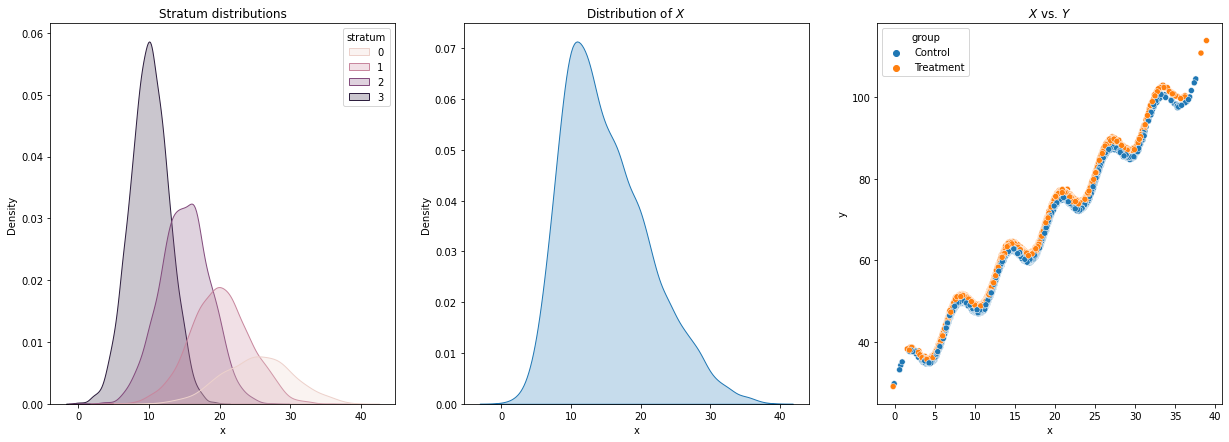

In [4]:
fig, axs = plt.subplots(1, 3, figsize=(21, 7))

sns.kdeplot(data=data, hue='stratum', x='x', fill=True, ax=axs[0])
axs[0].set_title('Stratum distributions')

sns.kdeplot(data=data, x='x', fill=True, ax=axs[1])
axs[1].set_title('Distribution of $X$')

sns.scatterplot(data=data, x='x', y='y', hue='group', ax=axs[2])
axs[2].set_title('$X$ vs. $Y$');

#### Утверждение №1: $t-test$ можно переформулировать в линейную регрессию

Для доказательства мы сначала проверим $t-test$

Далее мы зафитим линейную регрессию

$$
Y_i = \theta_0 + \delta T_i
$$

где,
* $Y$ - целевая переменная
* $\delta$ - оценка аплифта
* $T_i$ - индикатор тритмента (контроль - 0, тритмент - 1)

In [5]:
stats.ttest_ind(
    data.query('group == "Treatment"')['y'],
    data.query('group == "Control"')['y'],
)

Ttest_indResult(statistic=4.404390420320902, pvalue=1.0718529011212456e-05)

In [6]:
X = data[['const', 'group_int']]
y = data['y']
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     19.40
Date:                Wed, 12 Jan 2022   Prob (F-statistic):           1.07e-05
Time:                        21:02:10   Log-Likelihood:                -39729.
No. Observations:               10000   AIC:                         7.946e+04
Df Residuals:                    9998   BIC:                         7.948e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         60.1313      0.182    330.641      0.0

Если мы посмотрим на $t-statistic$ и $p-value$ для переменной **group_int**, то мы заметим, что они идентичны значениям, которые мы получили во время проверки гипотезы

Тем самым мы потверждаем утверждение, что $t-test$ можно переформулировать в линейную регрессию

А коэффициент перед **group_int** равен аплифту. Мы можем даже это проверить

In [26]:
ABS_UPLIFT = (
    data.query('group == "Treatment"')['y'].mean()
    -
    data.query('group == "Control"')['y'].mean()
)
print(f'Аплифт от тритмента равен {ABS_UPLIFT: .4f}')

Аплифт от тритмента равен  1.1211


#### Пост-стратификация в деле

Для проверки метода мы сначала бутстрэпом измерим аплифт и его дисперсию

Далее мы зафитим регрессию как:
$$
Y_{stratum} = \theta_0 + \delta T + \theta_1 X_{stratum}
$$

Точно также как и до этого, но в этот раз мы еще включаем перенную $X_{stratum}$, которая обозначает страты.
Далее мы бутстрэпом измерим, что в итоге получится с аплифтом

100%|██████████| 10000/10000 [00:02<00:00, 3596.49it/s]


NO REDUCTION:
	95% confidence interval = [0.0088, 2.2579]
	Bias = -0.0109
	Stddev =  0.5757


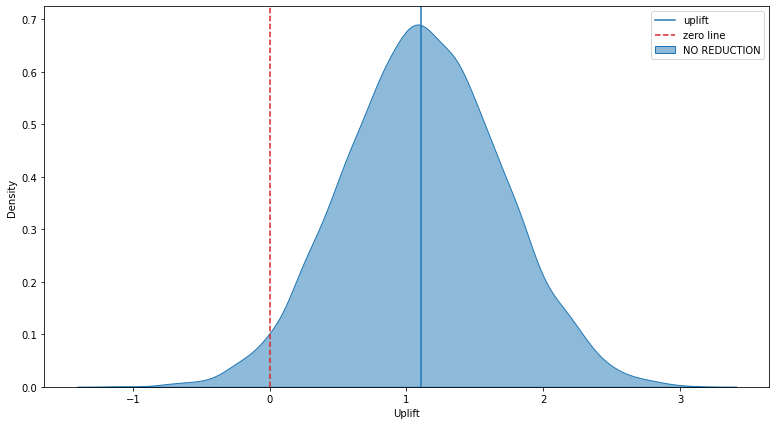

In [7]:
from utils import bootstrap as bt


bootstrap_rounds = 10000
means_no_reduction = bt.bootstrap_uplifts(
    data=data,
    rounds=bootstrap_rounds,
    X_names=['const', 'group_int'],
    y_name='y'
)
results_dict = bt.summarize_bootstrap(
    uplifts_list=[means_no_reduction],
    names_list=['NO REDUCTION'],
    abs_uplift=ABS_UPLIFT,
    alpha=config['alpha']
)

100%|██████████| 10000/10000 [00:03<00:00, 3290.21it/s]


NO REDUCTION:
	95% confidence interval = [0.0088, 2.2579]
	Bias = -0.0109
	Stddev =  0.5757
POST-STRATIFICATION:
	95% confidence interval = [0.4463, 1.7811]
	Bias = -0.0014
	Stddev =  0.3417


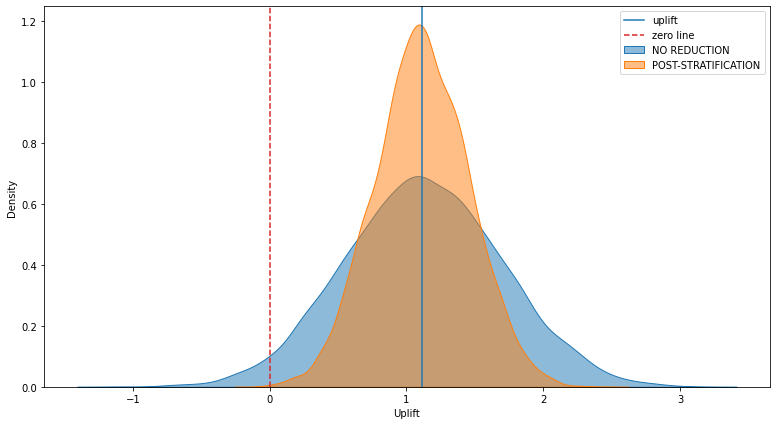

In [8]:
means_stratas = bt.bootstrap_uplifts(
    data=data,
    rounds=bootstrap_rounds,
    X_names=['const', 'group_int', 'stratum'],
    y_name='y'
)
results_dict = bt.summarize_bootstrap(
    uplifts_list=[means_no_reduction, means_stratas],
    names_list=['NO REDUCTION', 'POST-STRATIFICATION'],
    abs_uplift=ABS_UPLIFT,
    alpha=config['alpha']
)

Мы тут отчетливо видим, что пост-стартификация уменьшила дисперсию аплифта

Также очень важно, что оценка аплифта является несмещенной

Давайте теперь посмотрим на результаты OLS

In [27]:
print(statistics.summarize_ols(data, ['const', 'group_int'], 'y').tables[1])

                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         60.1374      0.182    330.705      0.000      59.781      60.494
group_int      1.1211      0.257      4.359      0.000       0.617       1.625


In [28]:
print(statistics.summarize_ols(data, ['const', 'group_int', 'stratum'], 'y').tables[1])

                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         80.6612      0.190    425.058      0.000      80.289      81.033
group_int      1.1211      0.155      7.235      0.000       0.817       1.425
stratum      -10.2619      0.077   -132.460      0.000     -10.414     -10.110


In [29]:
data['sin_x'] = np.sin(data['x'])
print(statistics.summarize_ols(data, ['const', 'x', 'sin_x'], 'y').tables[1])

                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         30.3020      0.016   1879.654      0.000      30.270      30.334
x              2.0198      0.001   2039.802      0.000       2.018       2.022
sin_x          4.0365      0.009    463.763      0.000       4.019       4.054


In [30]:
# 30 + 2x + 4sin(x)
print(statistics.summarize_ols(data, ['const', 'group_int', 'x', 'sin_x'], 'y').tables[1])

                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         29.6974      0.004   8300.886      0.000      29.690      29.704
group_int      1.2019      0.003    472.042      0.000       1.197       1.207
x              2.0201      0.000   9844.932      0.000       2.020       2.020
sin_x          4.0394      0.002   2239.663      0.000       4.036       4.043


In [31]:
print(statistics.summarize_ols(data.query('group == "Control"'), ['const', 'x', 'sin_x'], 'y').tables[1])

                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         30.0000   4.27e-15   7.03e+15      0.000      30.000      30.000
x              2.0000   2.62e-16   7.63e+15      0.000       2.000       2.000
sin_x          4.0000    2.3e-15   1.74e+15      0.000       4.000       4.000


In [32]:
print(statistics.summarize_ols(data.query('group != "Control"'), ['const', 'x', 'sin_x'], 'y').tables[1]) 

                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         30.6000   3.33e-15    9.2e+15      0.000      30.600      30.600
x              2.0400   2.05e-16   9.98e+15      0.000       2.040       2.040
sin_x          4.0800    1.8e-15   2.26e+15      0.000       4.080       4.080


In [34]:
from sklearn.linear_model import  LinearRegression

model = LinearRegression()
X = data[['const', 'x', 'sin_x']]
y = data['y']
thetas = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)
#agg.loc['Treatment'] - agg.loc['Control']
thetas = np.array([30.3, 2.02, 4.04])

In [39]:
data['y_pred'] = (X*thetas).sum(axis=1)
data['y_cuped'] = y - data['y_pred']
data.groupby('group')['y_cuped'].mean()

group
Control     -0.601374
Treatment    0.600574
Name: y_cuped, dtype: float64

In [40]:
data.groupby('group')['y_pred'].mean()

group
Control      60.738806
Treatment    60.657945
Name: y_pred, dtype: float64

In [44]:
data['y_pred_sk'] = model.fit(X, y).predict(X)
data.groupby('group')['y_pred_sk'].mean()

group
Control      60.738395
Treatment    60.657556
Name: y_pred_sk, dtype: float64

In [41]:
60.738806-60.657945

0.08086099999999874

In [17]:
model.intercept_, model.coef_

(30.30619463883189, array([2.01956769, 4.05414268]))

In [155]:
import statsmodels.formula.api as smf

mod = smf.ols(formula='y ~ group_int + stratum + x', data=data)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.950
Model:                            OLS   Adj. R-squared:                  0.950
Method:                 Least Squares   F-statistic:                 1.276e+04
Date:                Tue, 11 Jan 2022   Prob (F-statistic):               0.00
Time:                        21:27:12   Log-Likelihood:                -4931.0
No. Observations:                2000   AIC:                             9870.
Df Residuals:                    1996   BIC:                             9892.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     30.3265      0.479     63.288      0.0

Мы тут видим, что добавление новой переменной **stratum** никоим образом не изменил коэффициент перед **group_int**. Но дисперсия коэффициента (т.е. аплифта) была значительно уменьшена

И самое классное, что оценка аплифта и ее дисперсии совпадает с тем, что мы получили при бутстрэпе

Пост-стратификация уменьшает дисперсию за счет обнуления межгрупповой дисперсии. Давайте сверимся все ли так

In [13]:
agg = data.groupby('stratum')['y'].agg(['mean', 'var'])
stratum_shares = config['strata_shares']
within_strata_var = (stratum_shares*agg['var']).sum()
between_strata_var = (stratum_shares*(agg['mean'] - data['y'].mean())**2).sum()
total_var = within_strata_var + between_strata_var

print(f'Снижение согласно теории: {within_strata_var/total_var: .2%}')
print(f'Фактическое снижение по бутстрэпу: {means_stratas.var()/means_no_reduction.var(): .2%}')

Снижение согласно теории:  35.83%
Фактическое снижение по бутстрэпу:  35.23%


# CUPED

В целях уменьшения дисперсии целевой метрики, мы вводим новую переменную

$$
Y_{CUPED} = Y - \theta X
$$

Тут предлагается решить уравнение для $\theta$ таким образом, что дисперсия будет минимальной.

Таким образом решение для $\theta$:

$$
\theta = \frac{CoV(X, Y)}{Var(X)}
$$

Эта $\theta$ дает следующую дисперсию%

$$
Var(Y_{CUPED}) = Var(Y)(1-\rho^2)
$$

То есть изначальная дисперсия снижается на $(1-\rho^2)$, где $\rho$ - корреляция между X и Y

Если простыми словами, то мы хотим найти такую фичу, которая хорошо объясняет нашу целевую переменную. Также очень важно, чтобы распределение по группам во время тестов не зависело от этой фичи

В оригинальной статье, авторы рекоммендуют использовать ту же целевую переменную только за преэкспериментальный период. Поэтому и сложилось впечатление, что данный метод можно использовать только на старых пользователях. Но на самом деле это вовсе не так. Нам просто нужно хороший ковариат $X$, который соответствует 2 критериям:
* хорошо коррелирует с $Y$, так как от корреляции зависит насколько мы сможем уменьшить дисперсиб
* распределение по группам не зависит от ковариата

Таким образом, получается, что можно использовать любой ковариат, который соответсвует критериям выше. Например, можно использовать ранние экспериментальные фичи - тот же день захода в тест. Можно те же страты использовать

## Hands-on

Я тут не смог придумать хороший метод по генерации синтетических данных, где были бы преэкспериментальные данные. Но мы можем опробовать 2 ковариата на имеющихся данных: страты и $X$.

На самом деле, авторы рассказывают в своей статье, что пост-стратификация и CUPED должны дать одинаковый результат, если страты будут использованы в качестве ковариатов

Давайте сначала проверим все ли так

In [15]:
from tqdm.auto import tqdm

def bootstrap_uplifts_cuped(data, rounds, x_name, y_name):
    uplifts = []
    for _ in tqdm(range(rounds)):
        index = np.random.choice(range(len(data)), len(data), replace=True)
        delta = get_cuped(data.loc[index], x_name, y_name)
        uplifts.append(delta)
    return np.array(uplifts)


def get_cuped(data, x_name, y_name):
    cov_matrix = data.cov()
    theta = cov_matrix.loc[x_name, y_name] / cov_matrix.loc[x_name, x_name]
    y_cuped = data[y_name] - theta*data[x_name]
    mask = data['group_int'] == 1
    diff = y_cuped[mask].mean() - y_cuped[~mask].mean()
    return diff

100%|██████████| 10000/10000 [00:19<00:00, 507.37it/s]


NO REDUCTION:
	95% confidence interval = [0.0088, 2.2579]
	Bias = -0.0109
	Stddev =  0.5757
POST-STRATIFICATION:
	95% confidence interval = [0.4463, 1.7811]
	Bias = -0.0014
	Stddev =  0.3417
CUPED (stratum):
	95% confidence interval = [0.4584, 1.7711]
	Bias = -0.0026
	Stddev =  0.3379


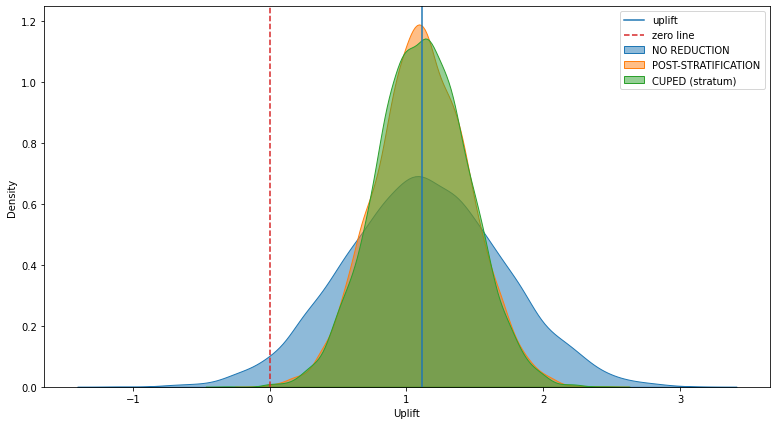

In [16]:
means_cuped_strat = bootstrap_uplifts_cuped(data, bootstrap_rounds, 'stratum', 'y')

_ = bt.summarize_bootstrap(
    uplifts_list=[means_no_reduction, means_stratas, means_cuped_strat],
    names_list=['NO REDUCTION', 'POST-STRATIFICATION', 'CUPED (stratum)'],
    abs_uplift=ABS_UPLIFT,
    alpha=0.05
)

y ~ const + stratum

y ~ const + x

$$
Y = 30 + 2X + 4sin(X) + \epsilon
$$

In [156]:
data.head()

,const,group_int,stratum,x,y,group,sin_x,y_pred
0,1,0,0,31.700817,94.394812,Control,0.281053,93.964166
1,1,1,0,33.687956,102.307089,Treatment,0.764047,100.140004
2,1,0,0,32.494942,98.384824,Control,0.881493,96.781010
3,1,1,0,23.856783,75.230240,Treatment,-0.956849,73.665822
4,1,0,0,35.155170,97.928499,Control,-0.562702,98.339404


NO REDUCTION:
	95% confidence interval = [0.0088, 2.2579]
	Bias = -0.0109
	Stddev =  0.5757
POST-STRATIFICATION:
	95% confidence interval = [0.4463, 1.7811]
	Bias = -0.0014
	Stddev =  0.3417
CUPED (stratum):
	95% confidence interval = [0.4584, 1.7711]
	Bias = -0.0026
	Stddev =  0.3379
CUPED (x):
	95% confidence interval = [1.0278, 1.5251]
	Bias = -0.1685
	Stddev =  0.1267


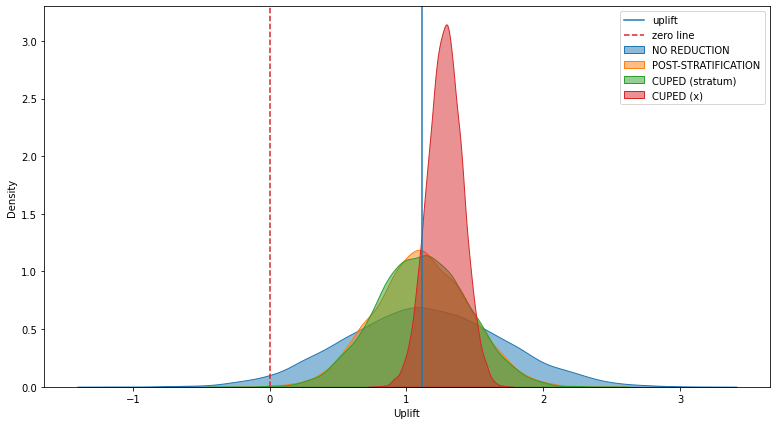

In [20]:
means_cuped_x = bootstrap_uplifts_cuped(data, bootstrap_rounds, 'x', 'y')

_ = bt.summarize_bootstrap(
    uplifts_list=[
        means_no_reduction, means_stratas, means_cuped_strat,
        means_cuped_x
    ],
    names_list=[
        'NO REDUCTION', 'POST-STRATIFICATION', 'CUPED (stratum)',
        'CUPED (x)'
    ],
    abs_uplift=ABS_UPLIFT,
    alpha=0.05
)

# CUPED - NonLinear

In [123]:
from sklearn.ensemble import RandomForestRegressor

def get_cuped(data, x_names, y_name):
    model = RandomForestRegressor(oob_score=True)
    X_arr = data[x_names].values
    y_arr = data[y_name].values

    model.fit(X_arr, y_arr)
    y_cuped = y_arr - model.oob_prediction_
    mask = data['group_int'] == 1
    diff = y_cuped[mask].mean() - y_cuped[~mask].mean()
    diff
    return diff

NO REDUCTION:
	95% confidence interval = [0.0088, 2.2579]
	Bias = -0.0109
	Stddev =  0.5757
POST-STRATIFICATION:
	95% confidence interval = [0.4463, 1.7811]
	Bias = -0.0014
	Stddev =  0.3417
CUPED (stratum):
	95% confidence interval = [0.4584, 1.7711]
	Bias = -0.0026
	Stddev =  0.3379
CUPED (X):
	95% confidence interval = [1.0278, 1.5251]
	Bias = -0.1685
	Stddev =  0.1267
CUPED - NONLINEAR:
	95% confidence interval = [0.5994, 0.6797]
	Bias =  0.4705
	Stddev =  0.0203


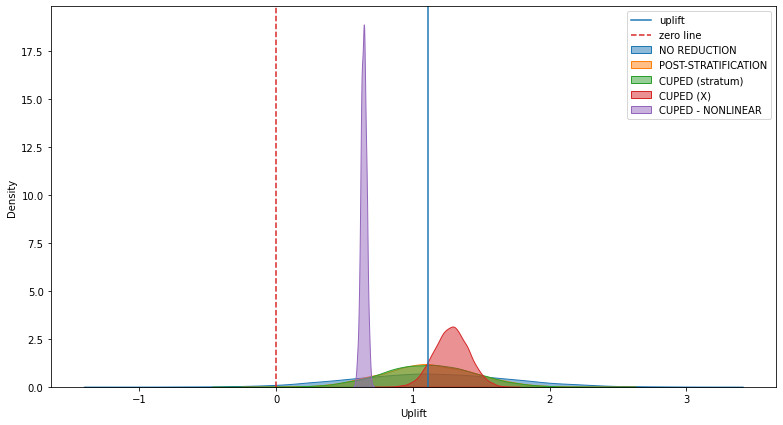

In [96]:
_ = bt.summarize_bootstrap(
    uplifts_list=[means_no_reduction, means_stratas, means_cuped_strat, means_cuped_x, means_cuped_rf],
    names_list=['NO REDUCTION', 'POST-STRATIFICATION', 'CUPED (stratum)', 'CUPED (X)', 'CUPED - NONLINEAR'],
    abs_uplift=ABS_UPLIFT,
    alpha=0.05
)

In [118]:
from sklearn.model_selection import KFold

def get_cuped(data, x_names, y_name):
    kfold = KFold(n_splits=10)
    model = RandomForestRegressor(oob_score=True)
    X_arr = data[x_names].values
    y_arr = data[y_name].values
    df = data.copy()
    df = df.reset_index()
    df['y_pred'] = np.nan
    for train_index, test_index in kfold.split(X):
        X_train, X_test = X_arr[train_index], X_arr[test_index]
        y_train, y_test = y_arr[train_index], y_arr[test_index]
        model.fit(X_train, y_train)
        df.loc[test_index, "y_pred"] = model.predict(X_test)
    
    y_cuped = df['y'] - df['y_pred']
    mask = df['group_int'] == 1
    diff = y_cuped[mask].mean() - y_cuped[~mask].mean()
    return diff

In [120]:
means_cuped_rf_kfold = bootstrap_uplifts_cuped(data, 100, ['x'], 'y')

100%|██████████| 100/100 [03:38<00:00,  2.18s/it]


NO REDUCTION:
	95% confidence interval = [0.0088, 2.2579]
	Bias = -0.0109
	Stddev =  0.5757
RF (KFOLD):
	95% confidence interval = [0.6417, 0.7253]
	Bias =  0.4292
	Stddev =  0.0204


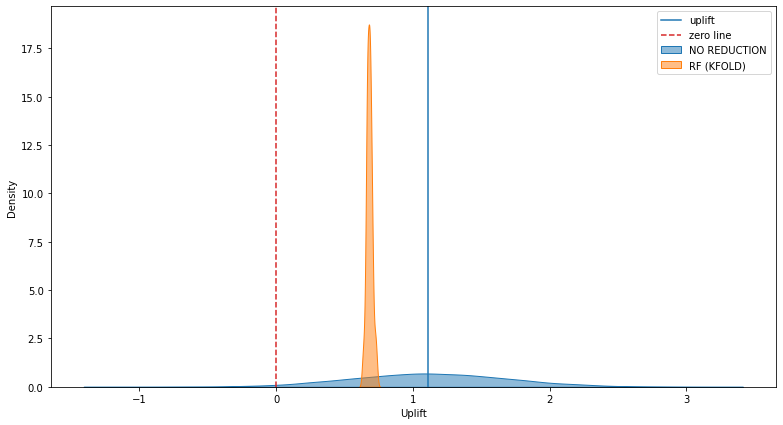

In [122]:
_ = bt.summarize_bootstrap(
    uplifts_list=[means_no_reduction, means_cuped_rf_kfold],
    names_list=['NO REDUCTION', 'RF (KFOLD)'],
    abs_uplift=ABS_UPLIFT,
    alpha=0.05
)

# CUPAC

In [131]:
np.random.seed(424242)

train_data = statistics.generate_stratification_data(config, f).query('group_int == 0')

In [141]:
from sklearn.metrics import mean_squared_error

x_names = ['sin_x', 'stratum', 'x']
train_data['sin_x'] = np.sin(train_data['x'])
X = train_data[x_names]
y = train_data['y']

model = RandomForestRegressor(n_estimators=3009, random_state=42)
model.fit(X, y)
y_pred = model.predict(X)
mean_squared_error(y, y_pred)**0.5

0.03935532613703273

In [142]:
data['y_pred'] = model.predict(data[x_names])

In [143]:
from tqdm.auto import tqdm

def bootstrap_uplifts_cuped(data, rounds, x_name, y_name):
    uplifts = []
    for _ in tqdm(range(rounds)):
        index = np.random.choice(range(len(data)), len(data), replace=True)
        delta = get_cuped(data.loc[index], x_name, y_name)
        uplifts.append(delta)
    return np.array(uplifts)


def get_cuped(data, x_name, y_name):
    cov_matrix = data.cov()
    theta = cov_matrix.loc[x_name, y_name] / cov_matrix.loc[x_name, x_name]
    y_cuped = data[y_name] - theta*data[x_name]
    mask = data['group_int'] == 1
    diff = y_cuped[mask].mean() - y_cuped[~mask].mean()
    return diff

In [144]:
means_cuped_cupac = bootstrap_uplifts_cuped(data, 10000, 'y_pred', 'y')

100%|██████████| 10000/10000 [00:17<00:00, 563.98it/s]


NO REDUCTION:
	95% confidence interval = [0.0088, 2.2579]
	Bias = -0.0109
	Stddev =  0.5757
POST-STRATIFICATION:
	95% confidence interval = [0.4463, 1.7811]
	Bias = -0.0014
	Stddev =  0.3417
CUPAC:
	95% confidence interval = [1.1601, 1.2047]
	Bias = -0.0741
	Stddev =  0.0114


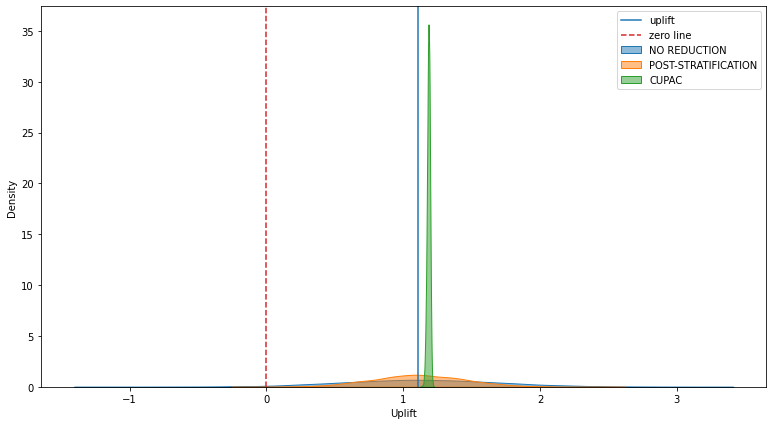

In [145]:
_=bt.summarize_bootstrap(
    uplifts_list=[means_no_reduction, means_stratas, means_cuped_cupac],
    names_list=['NO REDUCTION', 'POST-STRATIFICATION', 'CUPAC'],
    abs_uplift=ABS_UPLIFT,
    alpha=0.05
)